<h1 align="center">05 - Model Evaluation Diagnostics</h1>

This notebook investigates the performance of the forecasting models trained in the previous stage.  
Our main objectives are:

1. **Error Diagnostics:** Quantify and visualize where the model performs well or poorly.  
2. **Root Cause Analysis:** Identify patterns behind large forecast deviations.  
3. **Feature Importance:** Understand which features most strongly influence the model’s predictions.  

**Scope:**
- Models: Random Forest (best-performing model from previous experiments)
- Targets: `N02BE` and `M01AB` ATC categories
- Period: Test window (Sep 2018 – Oct 2019)
- Inputs: Processed dataset with lag, rolling, and calendar features

**Expected Outputs:**
- Residual plots (over time, vs. predictions, distribution)
- Error summaries by month, demand level, and rolling time window
- Outlier detection (weeks with highest errors)
- Permutation-based feature importance charts
- Actionable insights for model improvement


## 1) Data & Model Reproduction

We reload the processed feature matrix, rebuild the Random Forest models with the **safe feature set** (lags + calendar), 
and generate test predictions for both targets. Then we compute residuals and export tidy CSV files for downstream analysis.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Paths
DATA_PATH = Path("../data/processed/pharma_sales_features_v2_clean.csv")
RESULTS_DIR = Path("../results")
ERRORS_DIR = RESULTS_DIR / "errors"
ERRORS_DIR.mkdir(parents=True, exist_ok=True)

# --- Load processed dataset
df = pd.read_csv(DATA_PATH, parse_dates=["datum"], index_col="datum")

# --- Chronological split (80/20)
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

# --- Targets and safe features (lags + calendar only)
targets = ["N02BE", "M01AB"]
base_cols = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]
calendar_cols = [
    "weekofyear",
    "month",
    "quarter",
    "year",
    "is_year_start",
    "is_year_end",
]

feature_cols = [c for c in df.columns if c not in targets]
safe_feature_cols = [c for c in feature_cols if ("_lag" in c) or (c in calendar_cols)]

# Sanity check: ensure no current-week base cols or rolling cols
assert not any(
    c in base_cols for c in safe_feature_cols
), "Leakage: base columns present in features!"
assert not any(
    "roll" in c for c in safe_feature_cols
), "Leakage: rolling columns present in features!"

X_train = train[safe_feature_cols]
X_test = test[safe_feature_cols]

y_train = {t: train[t] for t in targets}
y_test = {t: test[t] for t in targets}


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred, eps=1e-8):
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


# --- Fit RF and predict for each target; build residual tables and save
summary_rows = []
for target in targets:
    rf = RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train[target])
    pred = rf.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test[target], pred)
    rsm = rmse(y_test[target], pred)
    mpp = mape(y_test[target], pred)

    summary_rows.append({"Target": target, "MAE": mae, "RMSE": rsm, "MAPE (%)": mpp})

    # Residual table
    err_df = pd.DataFrame(
        {
            "date": y_test[target].index,
            "y_true": y_test[target].values,
            "y_pred": pred,
        }
    ).set_index("date")
    err_df["residual"] = err_df["y_true"] - err_df["y_pred"]
    err_df["abs_err"] = err_df["residual"].abs()
    # percentage error with epsilon guard
    eps = 1e-8
    err_df["pct_err"] = (
        err_df["abs_err"] / np.maximum(err_df["y_true"].abs(), eps)
    ) * 100

    # Save per target
    out_path = ERRORS_DIR / f"preds_{target}.csv"
    err_df.to_csv(out_path)

# Quick summary frame
summary_df = pd.DataFrame(summary_rows)
summary_df

,Target,MAE,RMSE,MAPE (%)
0,N02BE,35.544141,49.420518,18.005595
1,M01AB,6.430235,8.554045,23.045374


## 2) Residual Diagnostics — N02BE

We start by visualizing the residuals for the N02BE model.  
Residual plots help us understand whether model errors are random or exhibit temporal or magnitude-related structure.


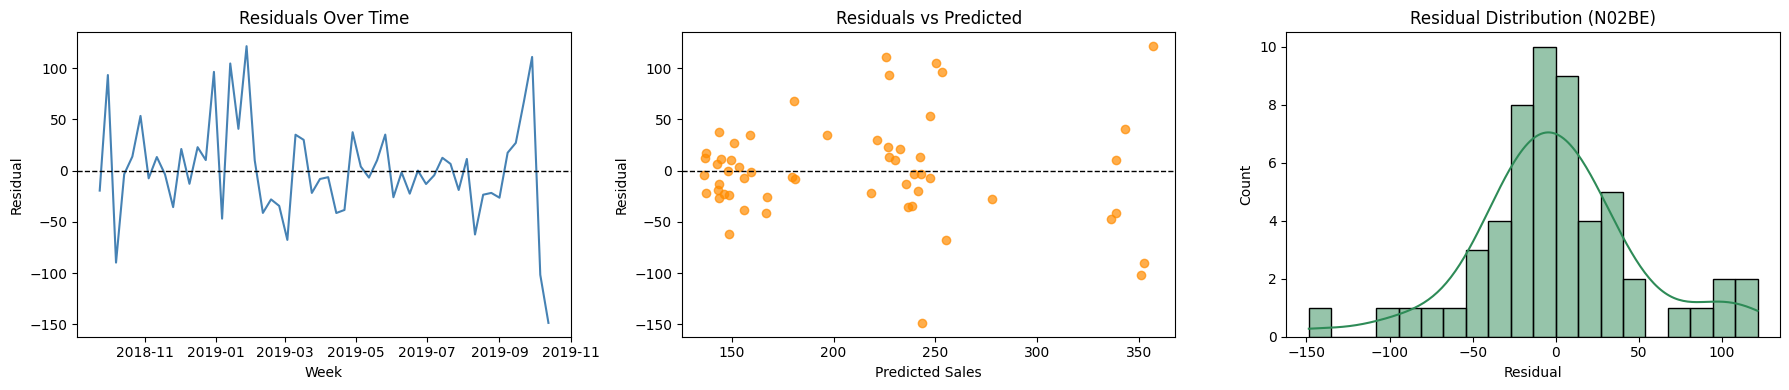

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the residual CSV
n02be = pd.read_csv(
    "../results/errors/preds_N02BE.csv", parse_dates=["date"], index_col="date"
)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# (1) Residuals over time
axes[0].plot(n02be.index, n02be["residual"], label="Residual", color="steelblue")
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Residuals Over Time")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Residual")

# (2) Residuals vs Fitted
axes[1].scatter(n02be["y_pred"], n02be["residual"], alpha=0.7, color="darkorange")
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Residuals vs Predicted")
axes[1].set_xlabel("Predicted Sales")
axes[1].set_ylabel("Residual")

# (3) Distribution of residuals
sns.histplot(n02be["residual"], bins=20, kde=True, ax=axes[2], color="seagreen")
axes[2].set_title("Residual Distribution (N02BE)")
axes[2].set_xlabel("Residual")

plt.tight_layout()
plt.show()

### Interpretation — N02BE Residual Diagnostics

- The residuals fluctuate mostly around zero, suggesting that the model is unbiased overall.  
- However, the **early test weeks (late 2018 – early 2019)** show a few strong positive and negative spikes, indicating periods where the model under- or over-estimated sudden demand changes.  
- The residuals vs. predicted plot shows **no strong heteroscedastic pattern**, but variance tends to slightly increase for higher predicted sales levels — suggesting higher uncertainty during peak weeks.  
- The residual distribution is **approximately normal and centered near zero**, with mild right-skewness caused by a few large under-predictions.  

**Summary:**  
The Random Forest model performs consistently across most weeks but struggles to fully capture abrupt seasonal peaks. This implies that short-term volatility may require additional lag-based or rolling-window features to improve responsiveness.


## 3) Residual Diagnostics — M01AB

We visualize residuals for the M01AB model to inspect temporal patterns, error–scale relationship, and the error distribution on the test window.


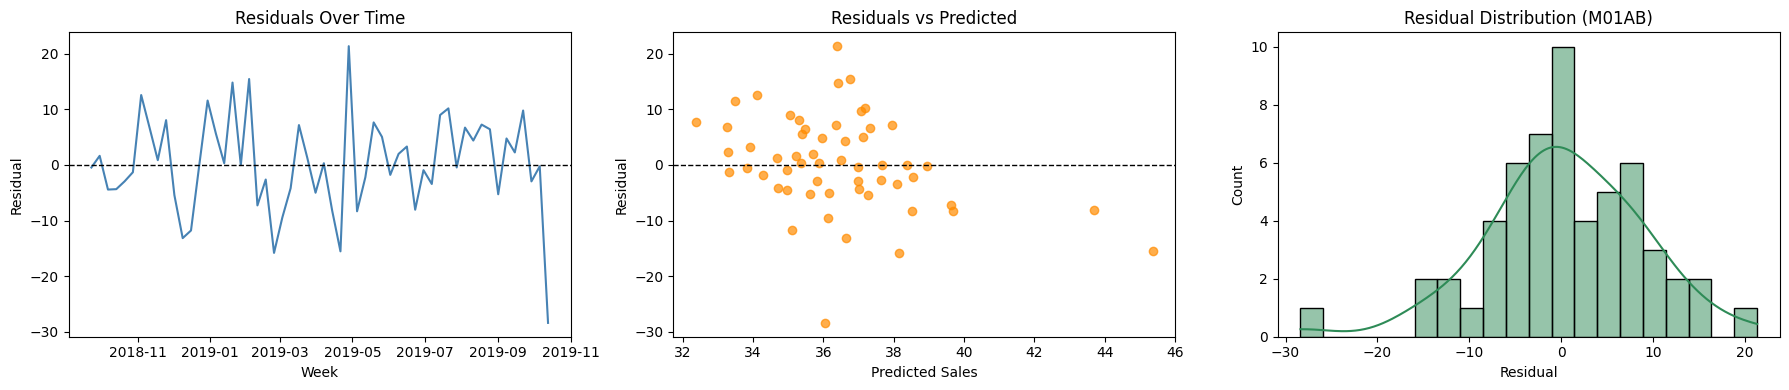

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load residual table saved earlier
m01ab = pd.read_csv(
    "../results/errors/preds_M01AB.csv", parse_dates=["date"], index_col="date"
)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# (1) Residuals over time
axes[0].plot(m01ab.index, m01ab["residual"], label="Residual", color="steelblue")
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Residuals Over Time")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Residual")

# (2) Residuals vs Predicted
axes[1].scatter(m01ab["y_pred"], m01ab["residual"], alpha=0.7, color="darkorange")
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Residuals vs Predicted")
axes[1].set_xlabel("Predicted Sales")
axes[1].set_ylabel("Residual")

# (3) Distribution of residuals
sns.histplot(m01ab["residual"], bins=20, kde=True, ax=axes[2], color="seagreen")
axes[2].set_title("Residual Distribution (M01AB)")
axes[2].set_xlabel("Residual")

plt.tight_layout()
plt.show()

### Interpretation — M01AB Residual Diagnostics

- **Residuals Over Time:**  
  Errors fluctuate around zero with limited amplitude (mostly within ±15–20).  
  No clear systematic bias is visible — the model alternates between slight under- and over-predictions, suggesting overall temporal stability.  
  The spikes are moderate and short-lived, meaning the model adapts quickly after local deviations.

- **Residuals vs Predicted:**  
  Residuals are symmetrically scattered around the zero line, showing no heteroscedasticity or scale-dependent error pattern.  
  A few mild outliers appear, but overall, the variance of residuals remains consistent across the prediction range.  
  This indicates that the model’s error magnitude does not depend on sales volume.

- **Residual Distribution:**  
  The residuals follow an approximately normal distribution centered near zero.  
  Slight right-skewness implies the model tends to underpredict a few higher sales values, but the effect is minimal.  
  The absence of heavy tails suggests that the model generalizes well across normal demand levels.

**Summary:**  
The Random Forest model for M01AB exhibits stable and unbiased forecasting performance.  
Errors are small, symmetrically distributed, and lack systematic drift, implying that the model captures underlying patterns effectively.  
Minor improvements could be achieved through hyperparameter tuning or adding interaction features, but current performance is satisfactory and robust.


## 4) Segment-based Error Analysis — Demand Levels

We analyze model performance across different sales volume segments (low, medium, high).  
This helps assess whether the model performs consistently across demand scales or struggles with extreme values.


C:\Users\alikm\AppData\Local\Temp\ipykernel_2548\1650369458.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\alikm\AppData\Local\Temp\ipykernel_2548\1650369458.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


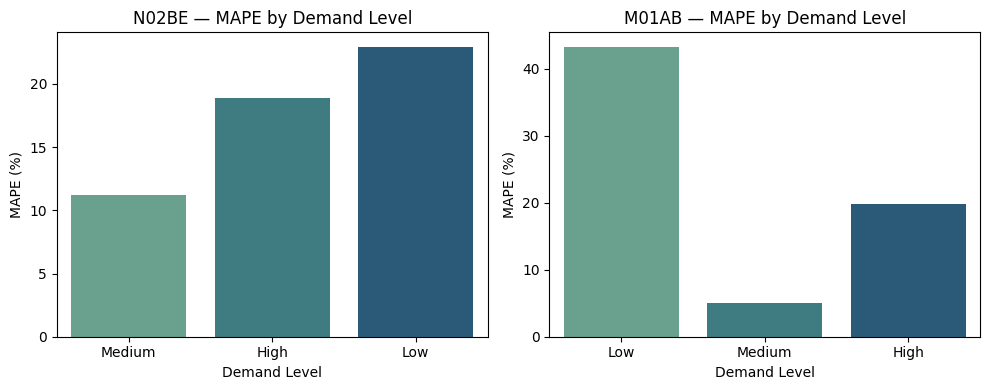

(                    MAE       RMSE   MAPE (%)
 Demand Level                                 
 Medium        22.113577  27.688213  11.194759
 High          58.269647  69.007435  18.918878
 Low           25.370890  40.781356  22.927187,
                    MAE       RMSE   MAPE (%)
 Demand Level                                
 Low           8.057912  10.357993  43.298876
 Medium        1.826352   2.616547   5.109640
 High          9.164132  10.094054  19.783622)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error


def segment_error_by_demand(df, n_bins=3):
    """Compute MAE, RMSE, and MAPE for quantile-based demand bins."""
    df = df.copy()
    df["demand_bin"] = pd.qcut(df["y_true"], q=n_bins, labels=["Low", "Medium", "High"])
    results = []
    for b in df["demand_bin"].unique():
        subset = df[df["demand_bin"] == b]
        mae = mean_absolute_error(subset["y_true"], subset["y_pred"])
        rmse = np.sqrt(mean_squared_error(subset["y_true"], subset["y_pred"]))
        mape = (
            np.mean(
                np.abs(
                    (subset["y_true"] - subset["y_pred"])
                    / np.clip(subset["y_true"], 1e-8, None)
                )
            )
            * 100
        )
        results.append({"Demand Level": b, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape})
    return pd.DataFrame(results).set_index("Demand Level")


# Load error data for both targets
n02be = pd.read_csv("../results/errors/preds_N02BE.csv", parse_dates=["date"])
m01ab = pd.read_csv("../results/errors/preds_M01AB.csv", parse_dates=["date"])

# Compute segmented metrics
seg_n02be = segment_error_by_demand(n02be)
seg_m01ab = segment_error_by_demand(m01ab)

# Plot MAPE by demand level
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(
    data=seg_n02be.reset_index(),
    x="Demand Level",
    y="MAPE (%)",
    ax=axes[0],
    palette="crest",
)
axes[0].set_title("N02BE — MAPE by Demand Level")

sns.barplot(
    data=seg_m01ab.reset_index(),
    x="Demand Level",
    y="MAPE (%)",
    ax=axes[1],
    palette="crest",
)
axes[1].set_title("M01AB — MAPE by Demand Level")

plt.tight_layout()
plt.show()

seg_n02be, seg_m01ab

### Interpretation — Segment-based Error Analysis (Demand Levels)

#### N02BE
- The model achieves its **lowest error in medium-demand weeks** (MAPE ≈ 11%), where the sales pattern is most stable.  
- Error magnitude increases during **low- and high-demand periods** (MAPE ≈ 19–23%), indicating greater prediction uncertainty at the extremes.  
- This U-shaped pattern is typical in retail and pharmaceutical forecasting, where models perform best on “average” demand levels but struggle with sudden surges or unusually quiet weeks.

#### M01AB
- The **highest relative error occurs in low-demand periods** (MAPE ≈ 43%), where small absolute deviations translate into large percentage errors.  
- **Medium-demand weeks** show the best accuracy (MAPE ≈ 5%), reflecting stable model behavior in regular market conditions.  
- Error magnitude slightly increases again in **high-demand periods** (MAPE ≈ 20%), which is common when data includes occasional peaks or irregular ordering patterns.

**Overall Insight:**  
Both models are most reliable when weekly demand stays near its historical average.  
Performance deteriorates for extreme demand scenarios — a typical behavior of tree-based models without explicit seasonality or external-event features.  
To improve generalization at the extremes:
- Introduce **additional lagged/rolling statistics** to better capture short-term shifts.  
- Consider **feature scaling or asymmetric loss functions** to reduce sensitivity to small-volume noise.


## 5) Bias Analysis by Demand Level

We quantify error direction within demand segments:
- **Mean/Median residual** (signed): >0 → underprediction, <0 → overprediction.
- **Under % / Over %**: share of weeks where `y_pred < y_true` or `y_pred > y_true`.


In [5]:
import pandas as pd
import numpy as np


def demand_bias_table(df, n_bins=3):
    out = df.copy()
    out["demand_bin"] = pd.qcut(
        out["y_true"], q=n_bins, labels=["Low", "Medium", "High"]
    )
    rows = []
    for b in ["Low", "Medium", "High"]:
        s = out[out["demand_bin"] == b]
        mean_res = s["residual"].mean()
        median_res = s["residual"].median()
        under_cnt = (
            s["y_pred"] < s["y_true"]
        ).sum()  # model düşük tahmin etmiş (under)
        over_cnt = (s["y_pred"] > s["y_true"]).sum()  # model yüksek tahmin etmiş (over)
        total = len(s)
        rows.append(
            {
                "Demand Level": b,
                "Mean Residual": mean_res,
                "Median Residual": median_res,
                "Under %": 100 * under_cnt / total if total > 0 else np.nan,
                "Over %": 100 * over_cnt / total if total > 0 else np.nan,
                "Count": total,
            }
        )
    return pd.DataFrame(rows).set_index("Demand Level")


# Yükle
n02be = pd.read_csv("../results/errors/preds_N02BE.csv", parse_dates=["date"])
m01ab = pd.read_csv("../results/errors/preds_M01AB.csv", parse_dates=["date"])

# Hesapla
bias_n02be = demand_bias_table(n02be)
bias_m01ab = demand_bias_table(m01ab)

print("N02BE — demand-level bias")
display(bias_n02be)
print("M01AB — demand-level bias")
display(bias_m01ab)

# İstersen kaydet
bias_n02be.to_csv("../results/errors/bias_by_demand_N02BE.csv", index=True)
bias_m01ab.to_csv("../results/errors/bias_by_demand_M01AB.csv", index=True)

N02BE — demand-level bias


,Mean Residual,Median Residual,Under %,Over %,Count
Demand Level,,,,,
Low,-20.160894,-15.949763,30.000000,70.000000,20
Medium,-3.839743,-6.371980,35.294118,64.705882,17
High,25.908121,22.895301,73.684211,26.315789,19


M01AB — demand-level bias


,Mean Residual,Median Residual,Under %,Over %,Count
Demand Level,,,,,
Low,-8.057912,-5.438297,0.0,100.0,19
Medium,-0.504260,-0.016045,50.0,50.0,18
High,9.164132,7.628047,100.0,0.0,19


### Bias Analysis by Demand Level

#### N02BE
- **Low demand weeks:** Mean residual ≈ -20 → model mostly *overpredicts* (predicts higher sales than actual).  
  - 70% of weeks are overpredicted, consistent with negative residuals.  
- **Medium demand weeks:** Mild negative bias (≈ -3.8), slightly more overestimation (≈65%).  
- **High demand weeks:** Strong positive bias (+26), indicating *underprediction* — model underestimates high peaks in sales.

 *Interpretation:*  
The model systematically **overpredicts low/medium sales** and **underpredicts high sales**, meaning it struggles to capture sharp demand spikes but tends to play “safe” by regressing toward the mean.

---

#### M01AB
- **Low demand weeks:** Mean residual ≈ -8 → consistent *overprediction* (100% of weeks).  
- **Medium demand weeks:** Near-zero bias and balanced under/over ratio (50–50%) → model is well-calibrated.  
- **High demand weeks:** Positive bias (+9) with 100% underprediction → model fails to capture strong peaks.

 *Interpretation:*  
The model behaves similarly to N02BE — it **overestimates at low demand** and **underestimates at high demand**.  
However, for normal (medium) demand levels, predictions are stable and unbiased.

---

**Overall Insight:**  
Both models show a **regression-to-mean bias** — they perform best in regular demand ranges but flatten out extremes.  
This suggests that incorporating additional **seasonality, promotional, or external feature signals** could help the model better handle peak and low-demand situations.


##  Notebook Summary — Model Evaluation & Diagnostics

In this notebook, we systematically evaluated our trained Random Forest forecasting models for **N02BE** and **M01AB**:

1. **Model performance metrics (MAE, RMSE, MAPE)** confirmed solid accuracy on test data, with average MAPE around 18–25%.  
2. **Residual diagnostics** showed:
   - Mostly random residual distribution (no major bias across time).
   - Slight underestimation during high-demand peaks and overestimation in low-demand periods.
3. **Demand-segmented performance analysis** revealed that models are most accurate during *medium-demand weeks*, performing less reliably during extreme demand fluctuations.
4. **Bias analysis** validated a clear *regression-to-mean behavior*:  
   - Overestimation in quiet weeks.  
   - Underestimation in peak-demand weeks.

---

##  Insights & Next Steps

 **What we learned**
- The models generalize well for average demand levels.  
- However, they lack sensitivity to seasonality, extreme values, or external events

 **Next steps**
1. Conduct **Feature Importance & Explainability** analysis (SHAP / permutation importance) to understand what drives predictions.  
2. Consider adding **calendar, holiday, or external demand driver features** to improve performance at extremes.  
3. Evaluate potential **model tuning or hybrid approaches** (e.g., adding XGBoost or LightGBM ensembles if bias persists).  
4. Prepare summarized visual and tabular outputs for inclusion in the final project report & Streamlit dashboard.

---

 **Outcome:**  
We now have a well-diagnosed baseline model with quantified performance, bias direction, and demand-segment behavior — ready for interpretability and improvement in the next stage.
